## Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import math
import warnings
import scvelo as scv
import cellrank as cr
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=500, frameon=False, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True)

## Load Segmentoid velocity

In [2]:
adata = sc.read('data/sample_1_segmentoid_48h_velo_originalmatrix.h5ad')

## Pre process

In [3]:
sc.pp.filter_cells(adata, min_counts=4000)
sc.pp.filter_cells(adata, max_counts=65000)
sc.pp.filter_cells(adata, min_genes=3000)
sc.pp.filter_cells(adata, max_genes=8000)

In [4]:
cell_cycle_genes = [x.strip() for x in open('utils/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [5]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
adata = adata[adata.obs['pct_counts_mito'] < 10, :]

In [6]:
adata.raw = adata

In [7]:
sc.pp.normalize_total(adata)

In [8]:
sc.pp.log1p(adata)

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=1500)

In [10]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'], n_jobs = 16)

... storing 'phase' as categorical


In [11]:
sc.pp.scale(adata)

In [12]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [13]:
sc.tl.umap(adata)

In [14]:
sc.tl.leiden(adata, resolution=.3, key_added='clusters')

In [15]:
adata.obs['clusters'] = adata.obs['clusters'].replace(['0'],'PSM')
adata.obs['clusters'] = adata.obs['clusters'].replace(['1'],'PSM')
adata.obs['clusters'] = adata.obs['clusters'].replace(['2'],'NMP')

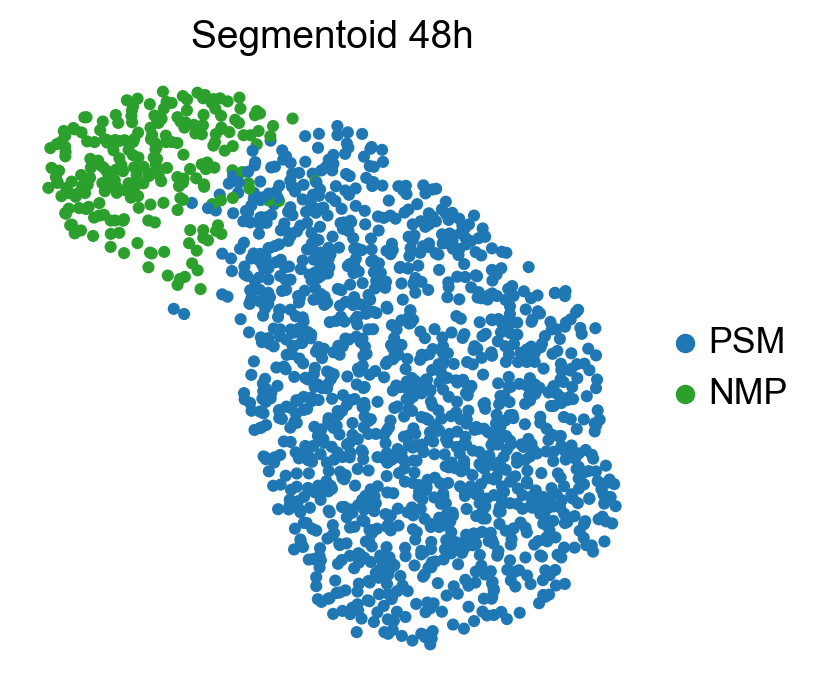

In [16]:
sc.pl.umap(adata, color=['clusters'], title='Segmentoid 48h', palette=['tab:blue', 'tab:green'])

In [17]:
scv.tl.velocity(adata, diff_kinetics=True)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1577 [00:00<?, ?cells/s]

C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\scvelo\core\_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


saving figure to file ./figures/scvelo_velocity_48h.svg


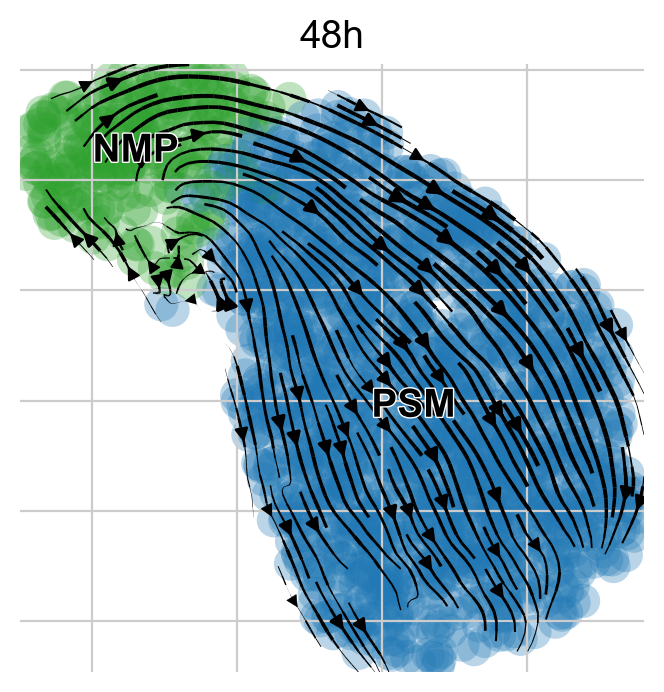

In [25]:
scv.pl.velocity_embedding_stream(adata, basis='umap', title='48h', save='velocity_48h.svg')

In [28]:
adata.obs['timepoint'] = '48h'
adata.write('data/sample_1_segmentoid_48h_velo_processed.h5ad')

... storing 'timepoint' as categorical
